In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hindi-poetry-dataset/sample_pukhraaj_7.txt
/kaggle/input/hindi-poetry-dataset/sample_naaraz_3.txt
/kaggle/input/hindi-poetry-dataset/sample_dhoopbahuthai_24.txt
/kaggle/input/hindi-poetry-dataset/sample_pukhraaj_9.txt
/kaggle/input/hindi-poetry-dataset/sample_dhoopbahuthai_61.txt
/kaggle/input/hindi-poetry-dataset/sample_dhoopbahuthai_79.txt
/kaggle/input/hindi-poetry-dataset/sample_dhoopbahuthai_85.txt
/kaggle/input/hindi-poetry-dataset/sample_naaraz_74.txt
/kaggle/input/hindi-poetry-dataset/sample_dhoopbahuthai_83.txt
/kaggle/input/hindi-poetry-dataset/sample_dhoopbahuthai_57.txt
/kaggle/input/hindi-poetry-dataset/sample_dhoopbahuthai_62.txt
/kaggle/input/hindi-poetry-dataset/sample_naaraz_78.txt
/kaggle/input/hindi-poetry-dataset/sample_pukhraaj_3.txt
/kaggle/input/hindi-poetry-dataset/sample_dhoopbahuthai_63.txt
/kaggle/input/hindi-poetry-dataset/sample_naaraz_63.txt
/kaggle/input/hindi-poetry-dataset/sample_naaraz_20.txt
/kaggle/input/hindi-poetry-dataset/sample_naar

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [5]:
tokenizer = Tokenizer()
path = '/kaggle/input/hindi-poetry-dataset/'
files = os.listdir(path)
#for i in files:
data = open(path+files[0]).read()
corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

#### I am not sure whether it makes sense to have a validation split for a poetry generation task. Perhaps not. Will try to train the model with and without the validation split

In [7]:
test_portion = 0.3
training_size = len(predictors)

split = int(test_portion * training_size)

#Train Validation split
valid_sequences = predictors[0:split]
training_sequences = predictors[split:training_size]
valid_labels = label[0:split]
training_labels = label[split:training_size]

print(valid_sequences.shape)
print(valid_labels.shape)

(324, 10)
(324, 635)


# Model 1

In [8]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           63500     
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 317)               32017     
_________________________________________________________________
dense_1 (Dense)              (None, 635)               201930    
Total params: 759,047
Trainable params: 759,047
Non-trainable params: 0
__________________________________________________

In [10]:
history = model.fit(training_sequences, training_labels, epochs=150,
                    validation_data=(valid_sequences, valid_labels), 
                    verbose=1)

Epoch 1/150
24/24 [==============================] - 1s 52ms/step - loss: 7.4642 - accuracy: 0.0238 - val_loss: 7.1995 - val_accuracy: 0.0247
Epoch 2/150
24/24 [==============================] - 0s 10ms/step - loss: 6.4328 - accuracy: 0.0384 - val_loss: 7.2641 - val_accuracy: 0.0185
Epoch 3/150
24/24 [==============================] - 0s 10ms/step - loss: 6.0171 - accuracy: 0.0238 - val_loss: 7.4684 - val_accuracy: 0.0494
Epoch 4/150
24/24 [==============================] - 0s 10ms/step - loss: 5.8348 - accuracy: 0.0423 - val_loss: 7.7679 - val_accuracy: 0.0494
Epoch 5/150
24/24 [==============================] - 0s 13ms/step - loss: 5.7114 - accuracy: 0.0278 - val_loss: 7.4979 - val_accuracy: 0.0494
Epoch 6/150
24/24 [==============================] - 0s 11ms/step - loss: 5.5608 - accuracy: 0.0397 - val_loss: 7.4429 - val_accuracy: 0.0185
Epoch 7/150
24/24 [==============================] - 0s 10ms/step - loss: 5.3463 - accuracy: 0.0357 - val_loss: 7.5824 - val_accuracy: 0.0401
Epoch 

24/24 [==============================] - 0s 11ms/step - loss: 3.3435 - accuracy: 0.2037 - val_loss: 16.0846 - val_accuracy: 0.0401
Epoch 59/150
24/24 [==============================] - 0s 10ms/step - loss: 3.3306 - accuracy: 0.2328 - val_loss: 15.9183 - val_accuracy: 0.0370
Epoch 60/150
24/24 [==============================] - 0s 10ms/step - loss: 3.2953 - accuracy: 0.2222 - val_loss: 16.1207 - val_accuracy: 0.0340
Epoch 61/150
24/24 [==============================] - 0s 16ms/step - loss: 3.2758 - accuracy: 0.2421 - val_loss: 16.2683 - val_accuracy: 0.0370
Epoch 62/150
24/24 [==============================] - 0s 14ms/step - loss: 3.2577 - accuracy: 0.2315 - val_loss: 16.4356 - val_accuracy: 0.0278
Epoch 63/150
24/24 [==============================] - 0s 10ms/step - loss: 3.2520 - accuracy: 0.2328 - val_loss: 16.3888 - val_accuracy: 0.0340
Epoch 64/150
24/24 [==============================] - 0s 10ms/step - loss: 3.2117 - accuracy: 0.2566 - val_loss: 16.4725 - val_accuracy: 0.0340
Epoch

Epoch 115/150
24/24 [==============================] - 0s 11ms/step - loss: 2.2852 - accuracy: 0.4537 - val_loss: 19.4146 - val_accuracy: 0.0370
Epoch 116/150
24/24 [==============================] - 0s 11ms/step - loss: 2.2658 - accuracy: 0.4630 - val_loss: 19.5147 - val_accuracy: 0.0340
Epoch 117/150
24/24 [==============================] - 0s 11ms/step - loss: 2.2364 - accuracy: 0.4934 - val_loss: 19.7126 - val_accuracy: 0.0340
Epoch 118/150
24/24 [==============================] - 0s 11ms/step - loss: 2.2338 - accuracy: 0.4881 - val_loss: 19.5966 - val_accuracy: 0.0309
Epoch 119/150
24/24 [==============================] - 0s 10ms/step - loss: 2.2280 - accuracy: 0.4683 - val_loss: 19.7744 - val_accuracy: 0.0370
Epoch 120/150
24/24 [==============================] - 0s 11ms/step - loss: 2.1855 - accuracy: 0.4934 - val_loss: 19.7587 - val_accuracy: 0.0370
Epoch 121/150
24/24 [==============================] - 0s 10ms/step - loss: 2.1823 - accuracy: 0.4987 - val_loss: 19.8020 - val_ac

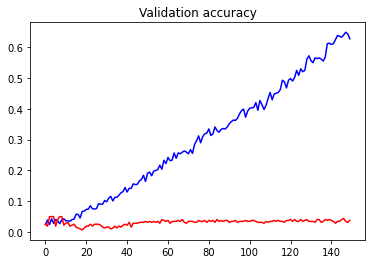

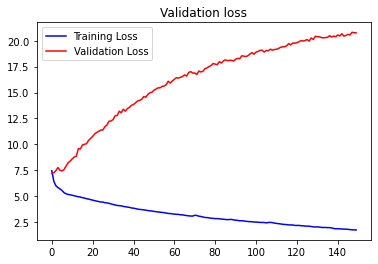

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Validation accuracy')


plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Validation loss')
plt.legend()

plt.show()

# Model 2

In [46]:
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))#, return_sequences = True)))
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(64))
#model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

ValueError: Input 0 of layer conv1d_5 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [None, 40]

In [42]:
history = model.fit(predictors, label, epochs=250,  batch_size = 64,verbose=1)

Epoch 1/250
17/17 [==============================] - 0s 6ms/step - loss: 6.4496 - accuracy: 0.0167
Epoch 2/250
17/17 [==============================] - 0s 6ms/step - loss: 6.4167 - accuracy: 0.0361
Epoch 3/250
17/17 [==============================] - 0s 6ms/step - loss: 6.2523 - accuracy: 0.0444
Epoch 4/250
17/17 [==============================] - 0s 6ms/step - loss: 5.8956 - accuracy: 0.0389
Epoch 5/250
17/17 [==============================] - 0s 6ms/step - loss: 5.7449 - accuracy: 0.0389
Epoch 6/250
17/17 [==============================] - 0s 6ms/step - loss: 5.7152 - accuracy: 0.0389
Epoch 7/250
17/17 [==============================] - 0s 6ms/step - loss: 5.6993 - accuracy: 0.0444
Epoch 8/250
17/17 [==============================] - 0s 6ms/step - loss: 5.6894 - accuracy: 0.0444
Epoch 9/250
17/17 [==============================] - 0s 6ms/step - loss: 5.6768 - accuracy: 0.0444
Epoch 10/250
17/17 [==============================] - 0s 6ms/step - loss: 5.6629 - accuracy: 0.0444
Epoch 11/

17/17 [==============================] - 0s 6ms/step - loss: 3.7476 - accuracy: 0.2204
Epoch 84/250
17/17 [==============================] - 0s 6ms/step - loss: 3.7410 - accuracy: 0.2139
Epoch 85/250
17/17 [==============================] - 0s 6ms/step - loss: 3.7491 - accuracy: 0.2176
Epoch 86/250
17/17 [==============================] - 0s 6ms/step - loss: 3.7336 - accuracy: 0.2231
Epoch 87/250
17/17 [==============================] - 0s 6ms/step - loss: 3.6892 - accuracy: 0.2306
Epoch 88/250
17/17 [==============================] - 0s 6ms/step - loss: 3.6493 - accuracy: 0.2426
Epoch 89/250
17/17 [==============================] - 0s 6ms/step - loss: 3.6328 - accuracy: 0.2509
Epoch 90/250
17/17 [==============================] - 0s 6ms/step - loss: 3.6032 - accuracy: 0.2574
Epoch 91/250
17/17 [==============================] - 0s 6ms/step - loss: 3.5863 - accuracy: 0.2602
Epoch 92/250
17/17 [==============================] - 0s 6ms/step - loss: 3.5619 - accuracy: 0.2593
Epoch 93/250


17/17 [==============================] - 0s 7ms/step - loss: 2.0627 - accuracy: 0.6333
Epoch 165/250
17/17 [==============================] - 0s 6ms/step - loss: 2.0425 - accuracy: 0.6296
Epoch 166/250
17/17 [==============================] - 0s 6ms/step - loss: 2.0235 - accuracy: 0.6370
Epoch 167/250
17/17 [==============================] - 0s 6ms/step - loss: 2.0057 - accuracy: 0.6361
Epoch 168/250
17/17 [==============================] - 0s 6ms/step - loss: 1.9898 - accuracy: 0.6417
Epoch 169/250
17/17 [==============================] - 0s 6ms/step - loss: 1.9708 - accuracy: 0.6435
Epoch 170/250
17/17 [==============================] - 0s 7ms/step - loss: 1.9636 - accuracy: 0.6472
Epoch 171/250
17/17 [==============================] - 0s 6ms/step - loss: 1.9459 - accuracy: 0.6463
Epoch 172/250
17/17 [==============================] - 0s 6ms/step - loss: 1.9223 - accuracy: 0.6528
Epoch 173/250
17/17 [==============================] - 0s 6ms/step - loss: 1.9055 - accuracy: 0.6620
Epoc

17/17 [==============================] - 0s 6ms/step - loss: 1.0071 - accuracy: 0.8222
Epoch 246/250
17/17 [==============================] - 0s 6ms/step - loss: 0.9981 - accuracy: 0.8315
Epoch 247/250
17/17 [==============================] - 0s 6ms/step - loss: 0.9880 - accuracy: 0.8296
Epoch 248/250
17/17 [==============================] - 0s 6ms/step - loss: 0.9792 - accuracy: 0.8306
Epoch 249/250
17/17 [==============================] - 0s 6ms/step - loss: 0.9682 - accuracy: 0.8315
Epoch 250/250
17/17 [==============================] - 0s 7ms/step - loss: 0.9599 - accuracy: 0.8287


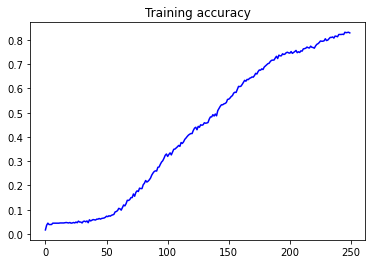

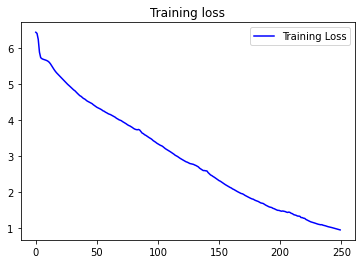

In [44]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [45]:
seed_text = "ज़िंदा रहन, सारे मौसमा,ली है आँखों ने"
next_words = 50
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

ज़िंदा रहन, सारे मौसमा,ली है आँखों ने कहीं से टकरा के बाद पास पीले करूँ क़ब्रें पीले पत्ते कहाँ कि घुटनों से आवाज़ें कहें आज से आवाज़ें मारेगी मेरे रहते से इसमें इसमें इसमें आदत पर खोलकर कहाँ पर खोलकर पर खोलकर दे नहीं है कैनवास के आक़ा' पीले पत्ते कहाँ कि जिनमें दुशाला ओढ़े पीले आक़ा'
